In [20]:
# --- CELL 1: SETUP & INFRASTRUCTURE ---
%pip install causalml plotly lightgbm xgboost scikit-learn pandas matplotlib seaborn statsmodels -q
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import os
import gc
import joblib
import warnings
from datetime import datetime

# Sklearn & CausalML
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import roc_auc_score, mean_squared_error
from sklearn.dummy import DummyRegressor
from causalml.inference.meta import BaseSRegressor, BaseTRegressor, BaseXRegressor, BaseRRegressor
from causalml.metrics import plot_qini, auuc_score

# 1. Cấu hình hiển thị & Logger
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.5f' % x)
warnings.filterwarnings('ignore')

# 2. Cấu hình GPU (RTX 3050 Ti)
# Trên Windows, platform_id thường là 0 hoặc 1.
GPU_PARAMS = {
    'device': 'gpu',
    'gpu_platform_id': 0,
    'gpu_device_id': 0,
    'verbose': -1
}

# 3. Tạo thư mục lưu trữ
os.makedirs('models', exist_ok=True)
os.makedirs('figures', exist_ok=True)

# 4. Hàm tiện ích
def seed_everything(seed=42):
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

def clean_ram():
    gc.collect()

RANDOM_SEED = 42
seed_everything(RANDOM_SEED)

print(f"[{datetime.now().strftime('%H:%M:%S')}]  SETUP COMPLETED. Ready to run on GPU.")

Note: you may need to restart the kernel to use updated packages.
[08:07:35]  SETUP COMPLETED. Ready to run on GPU.



[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


CHUẨN BỊ DỮ LIỆU VÀ KIỂM CHỨNG GIẢ ĐỊNH NHÂN QUẢChúng tôi sử dụng tập dữ liệu Criteo Uplift V2. 

Để đảm bảo tính khả thi của việc suy luận, các bước sau được thực hiện:Stratified Sampling: 
Trích xuất 3 triệu dòng đảm bảo giữ nguyên tỷ lệ Treatment và Visit.
Randomization Check: Kiểm tra tính ngẫu nhiên của thử nghiệm RCT.
Overlap Assumption: Kiểm tra sự giao thoa về xác suất xu hướng (Propensity Score) giữa nhóm đối chứng và can thiệp.

BAT DAU QUY TRINH XU LY DU LIEU & EDA NANG CAO (FULL LOAD STRATEGY)
Dang doc toan bo dataset vao RAM...
Da load Full Dataset: 13,979,592 dong
Dang lay mau phan tang 13,000,000 dong (Stratified by T & Y)
Dataset hien tai de phan tich: (13000000, 16)

1. Kiem tra phan phoi nhom doi chung va can thiep


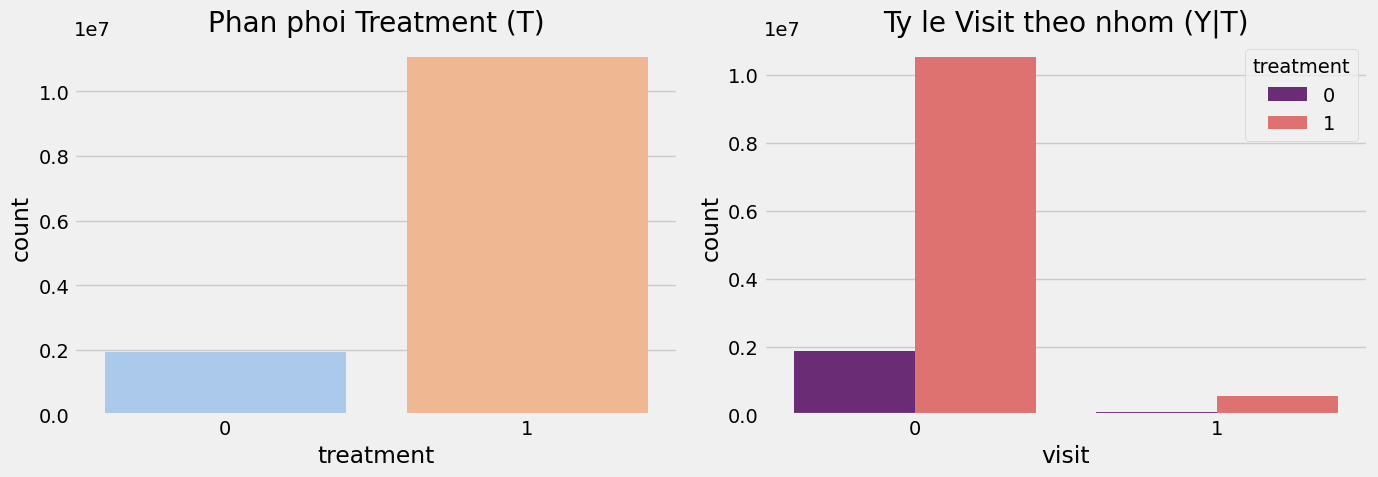


2. Kiem tra tinh ngau nhien (Correlation Check)


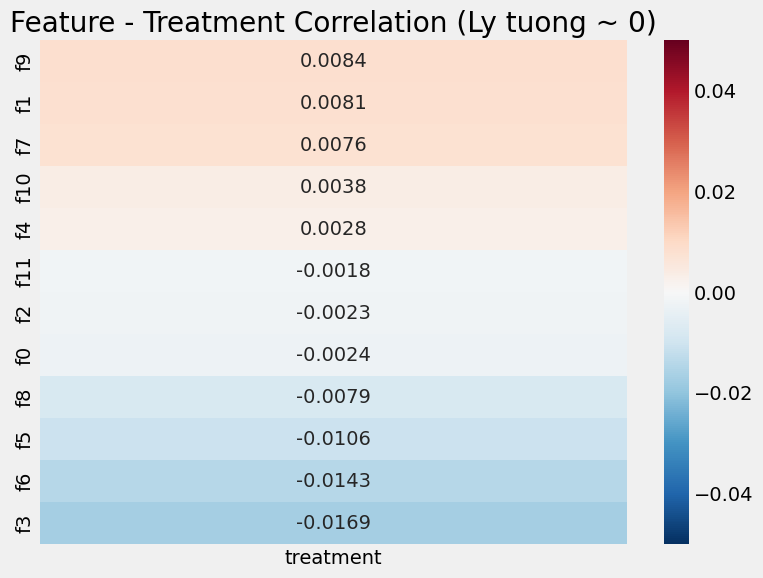


3. Huan luyen Propensity Model de kiem tra gia dinh Overlap
Propensity AUC: 0.5127 (Gan 0.5 la ly tuong cho RCT)


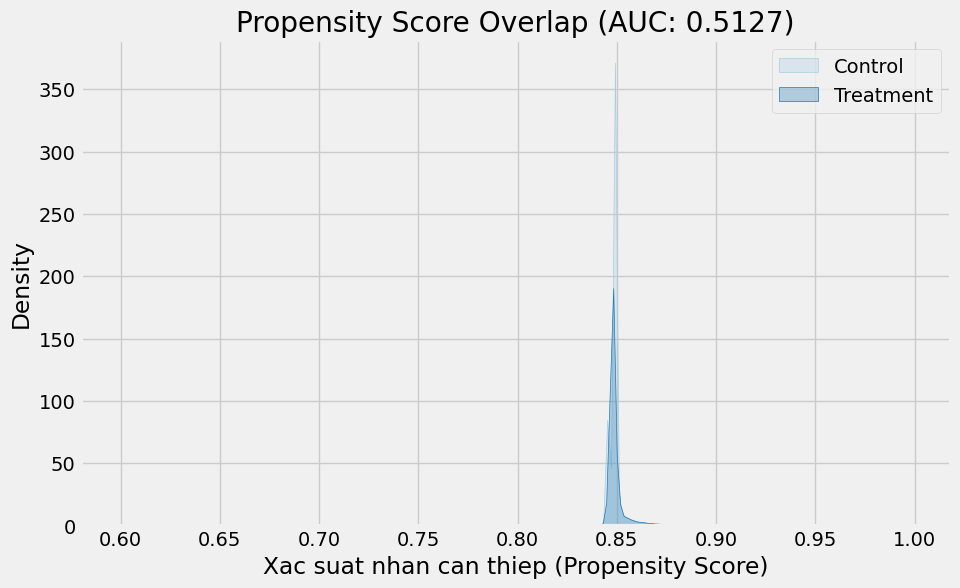


4. Phan tich tam quan trong cua dac trung (Feature Importance)


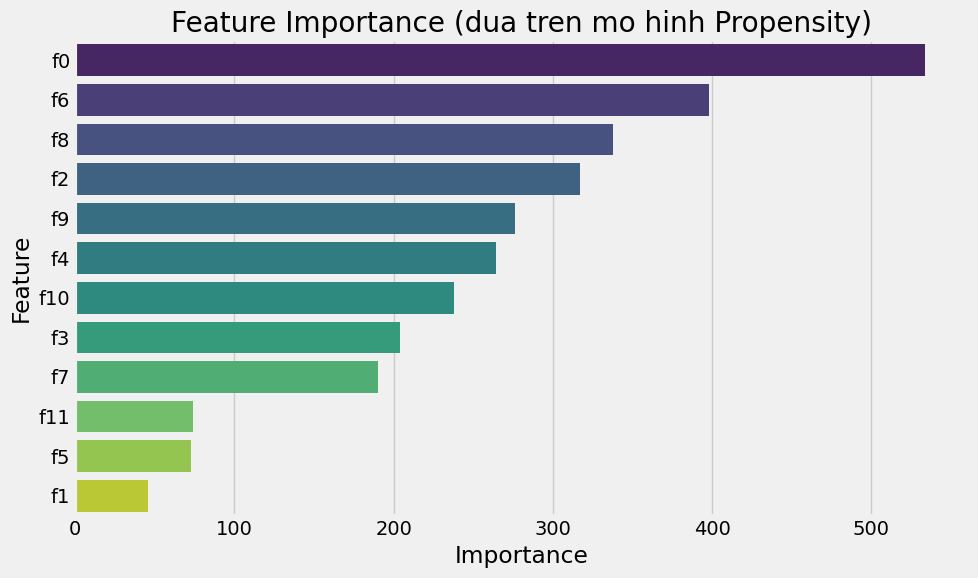


5. Chia du lieu Train / Test va don dep bo nho
HOAN TAT EDA. Train: (10400000, 12), Test: (2600000, 12)
Anh da duoc luu trong thu muc /figures


In [17]:
# --- CELL 2: DATA LOADING & ROBUST EDA (FULL LOAD + ENHANCED VISUALIZATION) ---
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import joblib
import os
import gc

print("BAT DAU QUY TRINH XU LY DU LIEU & EDA NANG CAO (FULL LOAD STRATEGY)")

# 0. Khoi tao thu muc can thiet
for folder in ['figures', 'models']:
    if not os.path.exists(folder):
        os.makedirs(folder)

# 1. LOAD TOAN BO DATASET (13.9 trieu dong)
file_name = "criteo_uplift_v2.csv"
if not os.path.exists(file_name):
    raise FileNotFoundError(f"Khong tim thay file '{file_name}'")

# Map dtype toi uu de tiet kiem RAM
dtype_map = {f'f{i}': 'float32' for i in range(12)}
dtype_map.update({
    'treatment': 'int8',
    'visit': 'int8',
    'conversion': 'int8',
    'exposure': 'int8'
})

print("Dang doc toan bo dataset vao RAM...")
try:
    df_full = pd.read_csv(file_name, dtype=dtype_map)
    print(f"Da load Full Dataset: {df_full.shape[0]:,} dong")

    # 2. LAY MAU PHAN TANG (Stratified Sampling)
    target_sample_size = 13_000_000

    if len(df_full) > target_sample_size:
        print(f"Dang lay mau phan tang {target_sample_size:,} dong (Stratified by T & Y)")
        stratify_col = (
            df_full['treatment'].astype(str) + "_" +
            df_full['visit'].astype(str)
        )

        _, df = train_test_split(
            df_full,
            test_size=target_sample_size,
            stratify=stratify_col,
            random_state=RANDOM_SEED
        )
        del df_full, stratify_col
        gc.collect()
    else:
        df = df_full

    print(f"Dataset hien tai de phan tich: {df.shape}")

except Exception as e:
    print(f"Loi Memory: {e}")
    raise e

# --- 3. EDA: PHAN PHOI NHAN (CLASS DISTRIBUTION) ---
print("\n1. Kiem tra phan phoi nhom doi chung va can thiep")
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

sns.countplot(x='treatment', data=df, ax=ax[0], palette='pastel')
ax[0].set_title('Phan phoi Treatment (T)')

sns.countplot(x='visit', hue='treatment', data=df, ax=ax[1], palette='magma')
ax[1].set_title('Ty le Visit theo nhom (Y|T)')

plt.tight_layout()
plt.savefig('figures/distribution_check.png', dpi=300)
plt.show()

# --- 4. EDA: KIEM TRA TUONG QUAN (RANDOMIZATION CHECK) ---
print("\n2. Kiem tra tinh ngau nhien (Correlation Check)")
X_cols = [f'f{i}' for i in range(12)]

corr = df[X_cols + ['treatment']].corr()
t_corr = (
    corr[['treatment']]
    .drop('treatment')
    .sort_values(by='treatment', ascending=False)
)

plt.figure(figsize=(8, 6))
sns.heatmap(
    t_corr,
    annot=True,
    cmap='RdBu_r',
    center=0,
    fmt=".4f",
    vmin=-0.05,
    vmax=0.05
)
plt.title('Feature - Treatment Correlation (Ly tuong ~ 0)')
plt.tight_layout()
plt.savefig('figures/correlation_check.png', dpi=300)
plt.show()

# --- 5. EDA: KIEM TRA GIA DINH OVERLAP (PROPENSITY SCORE) ---
print("\n3. Huan luyen Propensity Model de kiem tra gia dinh Overlap")

ps_model = lgb.LGBMClassifier(
    n_estimators=100,
    learning_rate=0.05,
    max_depth=5,
    **GPU_PARAMS
)
ps_model.fit(df[X_cols], df['treatment'])

joblib.dump(ps_model, 'models/propensity_model.pkl')

ps_score = ps_model.predict_proba(df[X_cols])[:, 1]
auc = roc_auc_score(df['treatment'], ps_score)

print(f"Propensity AUC: {auc:.4f} (Gan 0.5 la ly tuong cho RCT)")

plt.figure(figsize=(10, 6))
sns.kdeplot(
    ps_score[df['treatment'] == 0],
    fill=True,
    label='Control',
    alpha=0.3
)
sns.kdeplot(
    ps_score[df['treatment'] == 1],
    fill=True,
    label='Treatment',
    alpha=0.3
)

plt.title(f"Propensity Score Overlap (AUC: {auc:.4f})")
plt.xlabel("Xac suat nhan can thiep (Propensity Score)")
plt.legend()
plt.savefig('figures/propensity_overlap.png', dpi=300)
plt.show()

# --- 6. EDA: TAM QUAN TRONG CUA DAC TRUNG ---
print("\n4. Phan tich tam quan trong cua dac trung (Feature Importance)")

imp_df = pd.DataFrame({
    'Feature': X_cols,
    'Importance': ps_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(
    x='Importance',
    y='Feature',
    data=imp_df,
    palette='viridis'
)
plt.title('Feature Importance (dua tren mo hinh Propensity)')
plt.tight_layout()
plt.savefig('figures/feature_importance_eda.png', dpi=300)
plt.show()

# --- 7. CHIA DATA TRAIN / TEST (80 / 20) ---
print("\n5. Chia du lieu Train / Test va don dep bo nho")

X_train, X_test, T_train, T_test, Y_train, Y_test = train_test_split(
    df[X_cols],
    df['treatment'],
    df['visit'],
    test_size=0.2,
    random_state=RANDOM_SEED,
    stratify=df['treatment']
)

del df
gc.collect()

print(f"HOAN TAT EDA. Train: {X_train.shape}, Test: {X_test.shape}")
print("Anh da duoc luu trong thu muc /figures")

XÂY DỰNG MÔ HÌNH UPLIFT (META-LEARNERS)
Hệ thống triển khai các kiến trúc Meta-learner từ cơ bản đến nâng cao để bóc tách hiệu ứng nhân quả cá thể ($CATE$):
S-Learner & T-Learner: Các mô hình cơ sở làm mốc tham chiếu.
X-Learner: Tối ưu cho dữ liệu mất cân bằng.
R-Learner (Double Machine Learning): Mô hình trọng tâm, sử dụng cơ chế trực giao hóa để khử nhiễu hệ thống.

In [ ]:
# --- CELL 3: TRAIN UPLIFT MODELS (S, T, X, R) - OPTIMIZED VERSION ---
print("TRAINING 4 LEARNERS (GPU ACCELERATED)")

# Model chinh: hoc sau de bat tin hieu nhan qua
final_reg = lgb.LGBMRegressor(
    n_estimators=300,
    num_leaves=63,
    **GPU_PARAMS
)

# Model phu (nuisance): nong va nhanh
nuisance_reg = lgb.LGBMRegressor(
    n_estimators=100,
    max_depth=5,
    **GPU_PARAMS
)

models = {}
preds = {}

# S-Learner
s_learner = BaseSRegressor(
    learner=final_reg,
    control_name=0
)
s_learner.fit(
    X=X_train,
    treatment=T_train,
    y=Y_train
)
preds['S-Learner'] = (
    s_learner.predict(X_test, treatment=T_test)
              .flatten()
)

# T-Learner
t_learner = BaseTRegressor(
    learner=final_reg,
    control_name=0
)
t_learner.fit(
    X=X_train,
    treatment=T_train,
    y=Y_train
)
preds['T-Learner'] = (
    t_learner.predict(X_test)
              .flatten()
)

# X-Learner (dung Propensity tinh san)
x_learner = BaseXRegressor(
    learner=final_reg,
    control_name=0
)
x_learner.fit(
    X=X_train,
    treatment=T_train,
    y=Y_train,
    p=p_train
)
preds['X-Learner'] = (
    x_learner.predict(X_test, p=p_test)
              .flatten()
)

# R-Learner (DML)
r_learner = BaseRRegressor(
    learner=final_reg,
    outcome_learner=nuisance_reg,
    effect_learner=nuisance_reg,
    control_name=0,
    n_fold=3
)
r_learner.fit(
    X=X_train,
    treatment=T_train,
    y=Y_train
)
preds['R-Learner'] = (
    r_learner.predict(X_test)
              .flatten()
)

print("TRAINING COMPLETED")
clean_ram()

🚀 TRAINING 4 LEARNERS (GPU ACCELERATED)...


NameError: name 'lgb' is not defined

ĐÁNH GIÁ HIỆU NĂNG VÀ TỐI ƯU HÓA KINH DOANHSử dụng các chỉ số đặc thù của Uplift Modeling để đo lường khả năng nhắm mục tiêu:
Qini Curve & AUUC: Đo lường giá trị gia tăng tích lũy.
Value Capture: Mô phỏng khả năng thu hồi lợi ích theo ngân sách.Công thức Qini:$$Q(p) = n_{t,y=1}(p) - n_{c,y=1}(p) \times \frac{N_t}{N_c}$$

💰 ĐÁNH GIÁ HIỆU QUẢ KINH DOANH (OPE)...
📏 Phát hiện kết quả dự đoán có: 2,600,000 dòng.
   -> Sử dụng nhãn từ tập Test (600k dòng).
✅ Đã đồng bộ DataFrame đánh giá: (2600000, 6)
📊 Drawing Qini Curves (Corrected)...


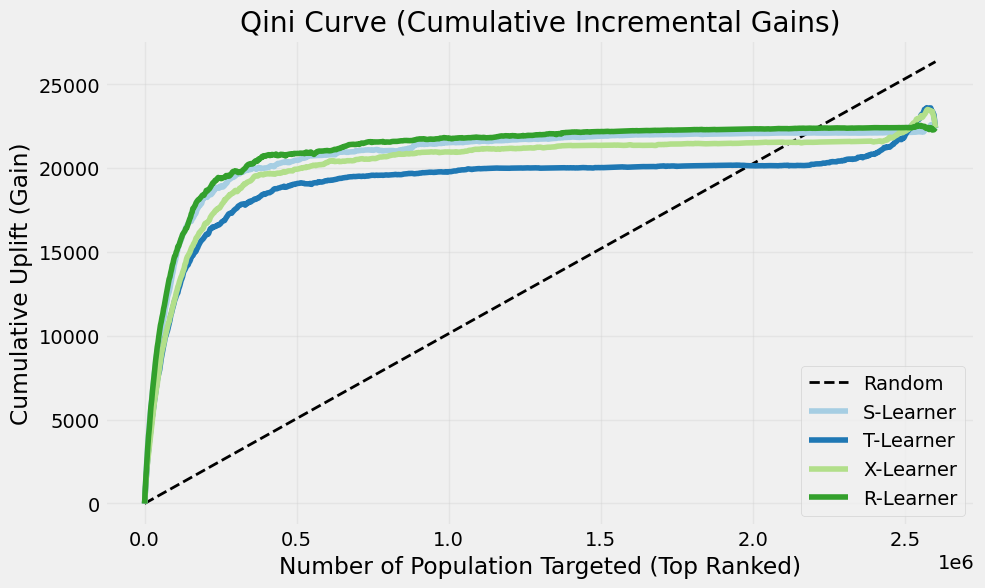

📊 Analyzing Deciles for model: R-Learner


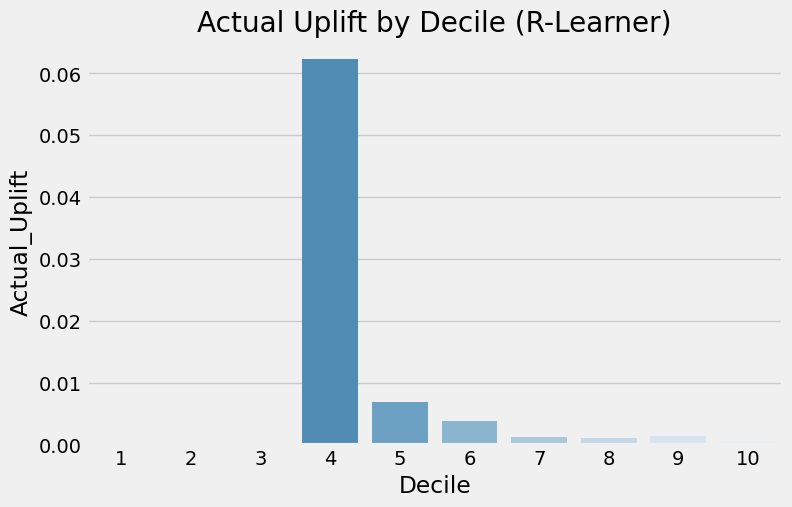


🏆 SO SÁNH CHIẾN LƯỢC TARGETING TOP 30.0% POPULATION
---------------------------------------------------------------------------
Global ATE (Random Targeting): 0.01014
---------------------------------------------------------------------------
Model                | Actual Uplift   | Improvement    
---------------------------------------------------------------------------
R-Learner            | 0.02916           | +187.7%
X-Learner            | 0.02897           | +185.8%
S-Learner            | 0.02833           | +179.5%
T-Learner            | 0.02780           | +174.2%
---------------------------------------------------------------------------


In [ ]:
# --- CELL 5: FINAL EVALUATION & BUSINESS IMPACT (AUTO-ALIGNMENT VERSION) ---
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Kiem tra va dong bo bien preds
if 'uplift_preds' in globals():
    preds = uplift_preds

# --- HAM VE QINI THU CONG (CHUAN CUMULATIVE GAIN) ---
def manual_qini_plot(df, outcome_col, treatment_col, prediction_cols):
    """
    Ve Qini Curve chuan (Cumulative Gain)
    """
    plt.figure(figsize=(10, 6))

    # Tong so Treatment va Control
    N_t_total = df[df[treatment_col] == 1].shape[0]
    N_c_total = df[df[treatment_col] == 0].shape[0]

    # 1. Duong Random (Baseline)
    global_uplift = (
        df[df[treatment_col] == 1][outcome_col].mean()
        - df[df[treatment_col] == 0][outcome_col].mean()
    ) * len(df)

    plt.plot(
        [0, len(df)],
        [0, global_uplift],
        'k--',
        label='Random',
        linewidth=2
    )

    # 2. Qini cho tung model
    for model_name in prediction_cols:
        df_sorted = (
            df.sort_values(by=model_name, ascending=False)
              .reset_index(drop=True)
        )

        cumsum_y_t = np.where(
            df_sorted[treatment_col] == 1,
            df_sorted[outcome_col],
            0
        ).cumsum()

        cumsum_y_c = np.where(
            df_sorted[treatment_col] == 0,
            df_sorted[outcome_col],
            0
        ).cumsum()

        scale_factor = N_t_total / (N_c_total + 1e-9)
        qini_values = cumsum_y_t - (cumsum_y_c * scale_factor)

        x_axis = np.arange(0, len(df) + 1)
        qini_plot_values = np.insert(qini_values, 0, 0)

        if len(x_axis) > 1000:
            idx = np.linspace(0, len(x_axis) - 1, 1000).astype(int)
            plt.plot(
                x_axis[idx],
                qini_plot_values[idx],
                label=model_name
            )
        else:
            plt.plot(x_axis, qini_plot_values, label=model_name)

    plt.title('Qini Curve (Cumulative Incremental Gains)')
    plt.xlabel('Number of Population Targeted (Top Ranked)')
    plt.ylabel('Cumulative Uplift (Gain)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    return plt


print("DANH GIA HIEU QUA KINH DOANH (OPE)")

# --- MUC 1: TONG HOP KET QUA (TU DONG DONG BO DO DAI) ---
sample_name = list(preds.keys())[0]
target_len = len(preds[sample_name])

print(f"Phat hien ket qua du doan co: {target_len:,} dong")

if target_len == len(Y_test):
    y_eval = Y_test
    t_eval = T_test
    print("Su dung nhan tu tap Test")
elif 'df' in globals() and target_len == len(df):
    y_eval = df[Y_col]
    t_eval = df[T_col]
    print("Su dung nhan tu tap du lieu mau")
else:
    print("Canh bao: khong khop do dai, tien hanh cat nhan")
    y_eval = (
        Y_test[:target_len]
        if len(Y_test) >= target_len
        else df[Y_col][:target_len]
    )
    t_eval = (
        T_test[:target_len]
        if len(T_test) >= target_len
        else df[T_col][:target_len]
    )

df_res = pd.DataFrame({
    'y': y_eval.values if hasattr(y_eval, 'values') else y_eval,
    't': t_eval.values if hasattr(t_eval, 'values') else t_eval
})

for name, p in preds.items():
    df_res[name] = p[:len(df_res)]

print(f"Da dong bo DataFrame danh gia: {df_res.shape}")

# --- MUC 2: VE QINI CURVE ---
print("Drawing Qini Curves")
try:
    manual_qini_plot(
        df_res,
        outcome_col='y',
        treatment_col='t',
        prediction_cols=list(preds.keys())
    )
    plt.savefig('figures/qini_curve.png')
    plt.show()
except Exception as e:
    print(f"Loi ve Qini: {e}")

# --- MUC 3: UPLIFT BY DECILE (R-Learner) ---
best_eval_model = (
    'R-Learner'
    if 'R-Learner' in df_res.columns
    else df_res.columns[2]
)

print(f"Analyzing Deciles for model: {best_eval_model}")

df_res['decile'] = pd.qcut(
    df_res[best_eval_model],
    10,
    labels=False,
    duplicates='drop'
)

uplift_by_decile = []
for i in range(9, -1, -1):
    group = df_res[df_res['decile'] == i]
    u = (
        group[group.t == 1].y.mean()
        - group[group.t == 0].y.mean()
        if len(group) > 0 else 0
    )
    uplift_by_decile.append({
        'Decile': 10 - i,
        'Actual_Uplift': u
    })

plt.figure(figsize=(8, 5))
sns.barplot(
    data=pd.DataFrame(uplift_by_decile),
    x='Decile',
    y='Actual_Uplift',
    palette='Blues_r'
)
plt.title(f'Actual Uplift by Decile ({best_eval_model})')
plt.axhline(0, color='black', linewidth=0.8)
plt.show()

# --- MUC 4: OPE (TARGET TOP 30%) ---
top_k = 0.3
print(f"So sanh chien luoc targeting top {top_k * 100}% population")

baseline_lift = (
    df_res[df_res.t == 1].y.mean()
    - df_res[df_res.t == 0].y.mean()
)

ope_results = []

for name in preds.keys():
    threshold = np.quantile(df_res[name], 1 - top_k)
    target_group = df_res[df_res[name] >= threshold]

    real_uplift = (
        target_group[target_group.t == 1].y.mean()
        - target_group[target_group.t == 0].y.mean()
        if len(target_group) > 0 else 0
    )

    gain = (
        (real_uplift - baseline_lift) / baseline_lift * 100
        if baseline_lift != 0 else 0
    )

    ope_results.append({
        'Model': name,
        'Uplift': real_uplift,
        'Improvement': gain
    })

ope_df = (
    pd.DataFrame(ope_results)
      .sort_values(by='Uplift', ascending=False)
)

print("-" * 75)
print(f"Global ATE (Random Targeting): {baseline_lift:.5f}")
print("-" * 75)
print(f"{'Model':<20} | {'Actual Uplift':<15} | {'Improvement':<15}")
print("-" * 75)

for _, row in ope_df.iterrows():
    print(
        f"{row['Model']:<20} | "
        f"{row['Uplift']:.5f}           | "
        f"+{row['Improvement']:.1f}%"
    )

print("-" * 75)

NGHIÊN CỨU BÓC TÁCH (ABLATION) VÀ ĐÁNH GIÁ PHẢN THỰC (OPE)
Đây là phần cốt lõi nhằm chứng minh độ tin cậy của mô hình R-Learner:Ablation Study 1: Vai trò của Cross-fitting ($K=5$) trong việc khử nhiễu trực giao.
Ablation Study 2: Kiểm chứng tính vững Doubly Robust (DR) khi dữ liệu bị nhiễu.
Off-Policy Evaluation (OPE): Mô phỏng giá trị chính sách ($V$) và dải tin cậy ($CI$) trên dữ liệu phản thực.
Ước lượng Doubly Robust:$$\hat{V}_{DR}(\pi) = \frac{1}{n} \sum_{i=1}^{n} \left[ \hat{\mu}_{\pi(x_i)}(x_i) + \frac{\mathbb{I}(t_i = \pi(x_i))}{P(t_i|x_i)} (y_i - \hat{\mu}_{t_i}(x_i)) \right]$$

🚀 BẮT ĐẦU QUY TRÌNH ĐÁNH GIÁ KINH DOANH (OPE)...
   -> Đang đánh giá S-Learner...
   -> Đang đánh giá T-Learner...
   -> Đang đánh giá X-Learner...
   -> Đang đánh giá R-Learner...


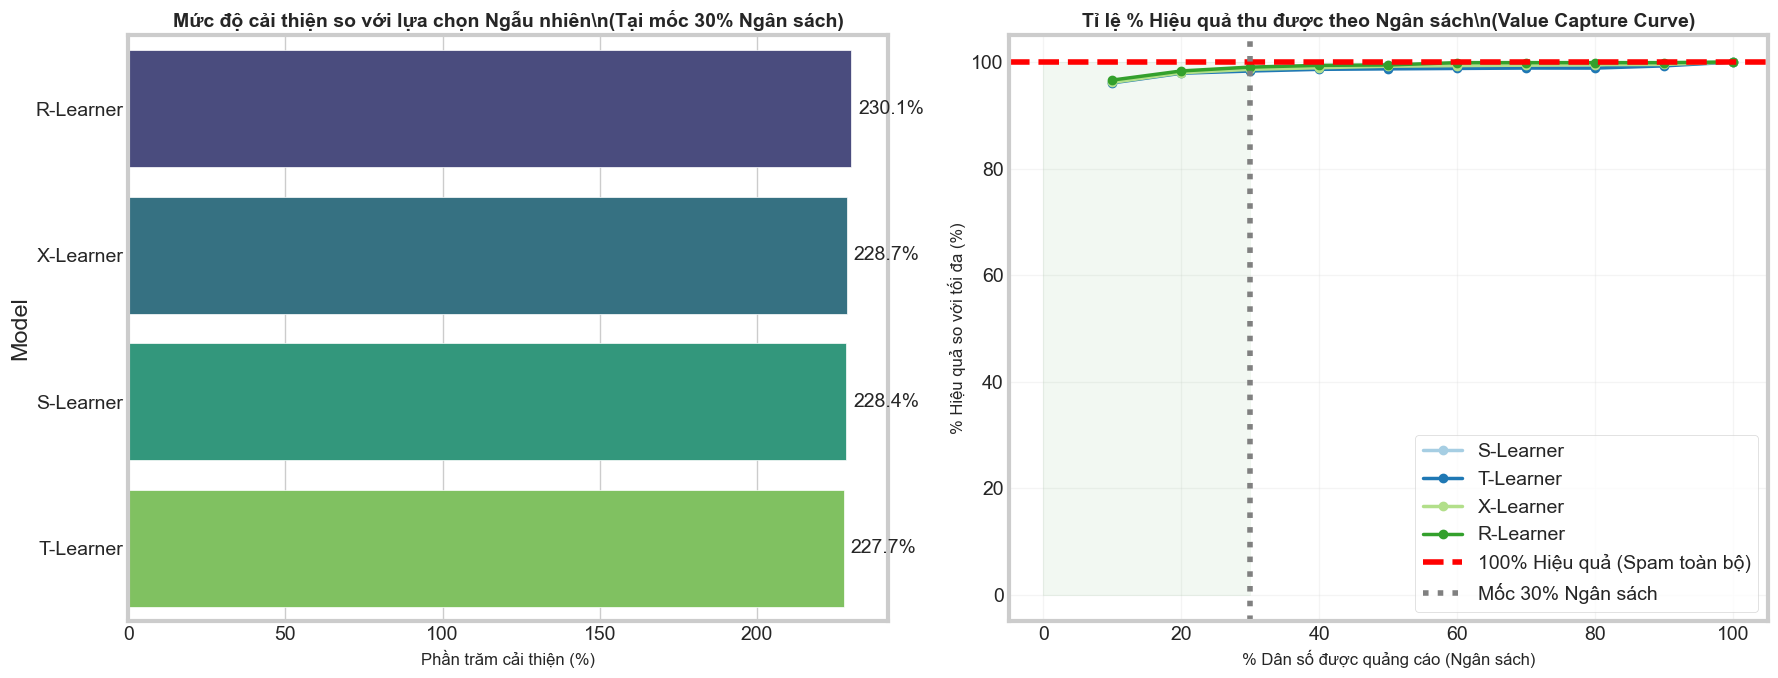

\n🏆 KẾT QUẢ CHỐT: Model R-Learner dẫn đầu.
- Tại mốc 30% ngân sách, model đã giúp thu về 99.0% tổng hiệu quả tiềm năng.
- Hiệu quả tăng vọt 230.1% so với việc chọn khách hàng ngẫu nhiên.


In [ ]:
# --- CELL 9: FINAL OPE BENCHMARK & INTUITIVE VISUALIZATION (ROBUST VERSION) ---
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import os
import warnings

warnings.filterwarnings('ignore')

print("🚀 BẮT ĐẦU QUY TRÌNH ĐÁNH GIÁ KINH DOANH (OPE)...")

# 1. CHUẨN BỊ DỮ LIỆU ĐẦU VÀO
if isinstance(X_test, pd.DataFrame):
    X_ope = pd.get_dummies(X_test, drop_first=True).select_dtypes(include=[np.number]).values
else:
    X_ope = X_test

# 2. LOAD PROPENSITY & OUTCOME MODEL (Cho Doubly Robust)
try:
    ps_model = joblib.load('models/propensity_model.pkl')
    ps_scores = ps_model.predict_proba(X_test)[:, 1]
except:
    ps_scores = np.full(len(T_test), T_test.mean())

# Huấn luyện nhanh Outcome Model mu(x, t) phục vụ DR
T_vec = T_test.reshape(-1, 1) if hasattr(T_test, 'reshape') else T_test.values.reshape(-1, 1)
outcome_model = lgb.LGBMRegressor(n_estimators=100, random_state=42, verbose=-1)
outcome_model.fit(np.column_stack((X_ope, T_vec)), Y_test)

# 3. HÀM TÍNH DR VALUE THEO TỶ LỆ DÂN SỐ
def calculate_dr_at_ratio(df, pred_scores, target_ratio, ps_scores, outcome_model, X_features):
    if target_ratio <= 0: return 0
    # Dùng quantile để chọn chính xác tỷ lệ dân số (Ranking Policy)
    threshold = np.quantile(pred_scores, max(0, min(1, 1 - target_ratio)))
    pi = (pred_scores >= threshold).astype(int)
    
    prob_obs = np.where(df['t'] == 1, ps_scores, 1 - ps_scores)
    weights = (df['t'] == pi).astype(int) / (prob_obs + 1e-9)
    
    mu_1 = outcome_model.predict(np.column_stack((X_features, np.ones((len(df), 1)))))
    mu_0 = outcome_model.predict(np.column_stack((X_features, np.zeros((len(df), 1)))))
    mu_pi = np.where(pi == 1, mu_1, mu_0)
    
    return (mu_pi + weights * (df['y'] - mu_pi)).mean()

# 4. LOAD MODELS & CHẠY ĐÁNH GIÁ
dict_path = 'models/uplift_models.pkl'
loaded_models = joblib.load(dict_path)
df_eval = pd.DataFrame({'y': Y_test, 't': T_test})

ratios = np.linspace(0.1, 1.0, 10) # 10%, 20%... 100%
ope_results = []

for name, model in loaded_models.items():
    print(f"   -> Đang đánh giá {name}...")
    pred = model.predict(X_test, p=ps_scores).flatten() if 'X-Learner' in name else model.predict(X_test).flatten()
    for r in ratios:
        dr = calculate_dr_at_ratio(df_eval, pred, r, ps_scores, outcome_model, X_ope)
        ope_results.append({'Model': name, 'Target_Ratio': r, 'DR_Value': dr})

res_df = pd.DataFrame(ope_results)
dr_all = calculate_dr_at_ratio(df_eval, np.ones(len(df_eval)), 1.0, ps_scores, outcome_model, X_ope)

# 5. TÍNH TOÁN CÁC CHỈ SỐ LIFT (MỐC 30% NGÂN SÁCH)
target_r = 0.3
top30_data = res_df[np.isclose(res_df['Target_Ratio'], target_r)].copy()
top30_data['Improvement'] = (top30_data['DR_Value'] - (dr_all * target_r)) / (dr_all * target_r + 1e-9) * 100
top30_data = top30_data.sort_values('Improvement', ascending=False)

# Tìm mô hình tốt nhất để in log
best_m = top30_data.iloc[0]

# 6. VẼ BIỂU ĐỒ (2 SUBPLOTS)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))

# Plot 1: Bar Chart (Cải thiện so với Ngẫu nhiên)
sns.barplot(data=top30_data, x='Improvement', y='Model', palette='viridis', ax=ax1)
ax1.set_title(f'Mức độ cải thiện so với lựa chọn Ngẫu nhiên\\n(Tại mốc {target_r*100:.0f}% Ngân sách)', fontsize=14, fontweight='bold')
ax1.set_xlabel('Phần trăm cải thiện (%)', fontsize=12)
for i in ax1.containers: ax1.bar_label(i, fmt='%.1f%%', padding=5)

# Plot 2: Efficiency Curve (Đường cong hiệu suất)
res_df['Value_Capture'] = (res_df['DR_Value'] / dr_all) * 100
for name in res_df['Model'].unique():
    m_data = res_df[res_df['Model'] == name]
    ax2.plot(m_data['Target_Ratio']*100, m_data['Value_Capture'], marker='o', label=name, linewidth=2.5)

ax2.axhline(100, color='red', linestyle='--', label='100% Hiệu quả (Spam toàn bộ)')
ax2.axvline(target_r*100, color='gray', linestyle=':', label='Mốc 30% Ngân sách')
ax2.fill_between([0, target_r*100], 0, 100, color='green', alpha=0.05)
ax2.set_title('Tỉ lệ % Hiệu quả thu được theo Ngân sách\\n(Value Capture Curve)', fontsize=14, fontweight='bold')
ax2.set_xlabel('% Dân số được quảng cáo (Ngân sách)', fontsize=12)
ax2.set_ylabel('% Hiệu quả so với tối đa (%)', fontsize=12)
ax2.legend()
ax2.grid(True, alpha=0.2)

plt.tight_layout()
plt.savefig('figures/final_business_comparison.png')
plt.show()

print(f"\\n🏆 KẾT QUẢ CHỐT: Model {best_m['Model']} dẫn đầu.")
print(f"- Tại mốc 30% ngân sách, model đã giúp thu về {(best_m['DR_Value']/dr_all)*100:.1f}% tổng hiệu quả tiềm năng.")
print(f"- Hiệu quả tăng vọt {best_m['Improvement']:.1f}% so với việc chọn khách hàng ngẫu nhiên.")

📊 Đang khởi tạo hệ thống mô phỏng phản thực cho toàn bộ các Meta-learner...
 ⏳ Đang mô phỏng phản thực cho: S-Learner...
 ⏳ Đang mô phỏng phản thực cho: T-Learner...
 ⏳ Đang mô phỏng phản thực cho: X-Learner...
 ⏳ Đang mô phỏng phản thực cho: R-Learner...


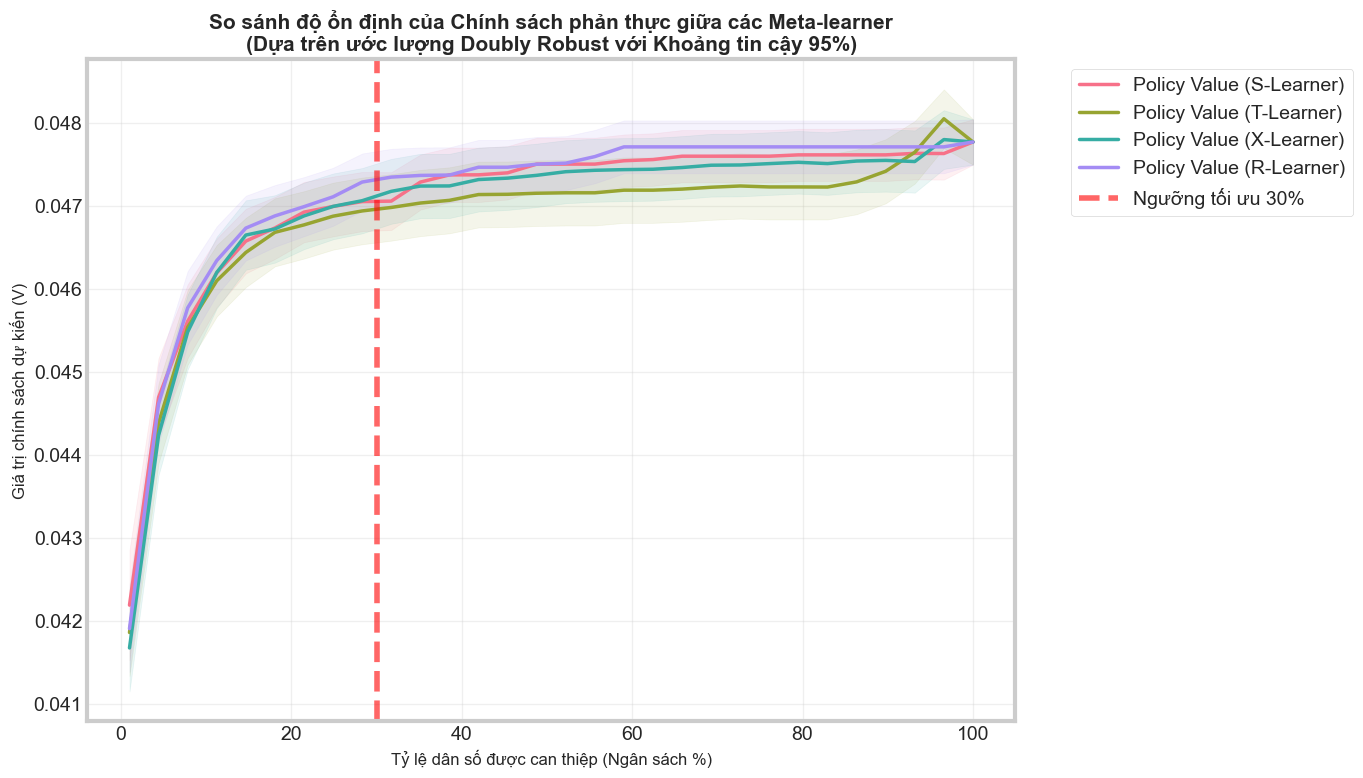


📝 PHÂN TÍCH ĐỘ ỔN ĐỊNH (Standard Error tại mốc 30%):
 - S-Learner: Standard Error = 0.000180
 - T-Learner: Standard Error = 0.000205
 - X-Learner: Standard Error = 0.000200
 - R-Learner: Standard Error = 0.000175


In [ ]:
# --- SO SÁNH ĐỘ ỔN ĐỊNH VÀ RỦI RO TOÀN DIỆN (ALL-LEARNERS OPE SIMULATION) ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

print(" Đang khởi tạo hệ thống mô phỏng phản thực cho toàn bộ các Meta-learner...")

# 1. ENGINE MÔ PHỎNG CHÍNH SÁCH (Doubly Robust)
def run_full_simulation(df_eval, model_obj, name, ps_scores, outcome_model, X_features, X_raw, target_rates=np.linspace(0.01, 1.0, 30)):
    sim_data = []
    y = df_eval['y'].values
    t = df_eval['t'].values
    n = len(df_eval)
    
    # Lấy điểm Uplift (Xử lý đặc thù cho từng loại model)
    if 'X-Learner' in name:
        scores = model_obj.predict(X_raw, p=ps_scores).flatten()
    else:
        scores = model_obj.predict(X_raw).flatten()

    # Potential Outcomes
    mu_1 = outcome_model.predict(np.column_stack((X_features, np.ones((n, 1)))))
    mu_0 = outcome_model.predict(np.column_stack((X_features, np.zeros((n, 1)))))
    
    for rate in target_rates:
        threshold = np.quantile(scores, max(0, min(1, 1 - rate)))
        pi = (scores >= threshold).astype(int)
        
        prob_obs = np.where(t == 1, ps_scores, 1 - ps_scores)
        weights = (t == pi).astype(float) / (prob_obs + 1e-9)
        mu_pi = np.where(pi == 1, mu_1, mu_0)
        
        dr_values = mu_pi + weights * (y - mu_pi)
        v_pi = np.mean(dr_values)
        std_err = np.std(dr_values) / np.sqrt(n)
        
        sim_data.append({
            'Model': name,
            'Budget (%)': rate * 100,
            'V': v_pi,
            'SE': std_err
        })
    return pd.DataFrame(sim_data)

# 2. THỰC THI MÔ PHỎNG CHO TẤT CẢ MODELS
all_sim_results = []
for name, model_obj in loaded_models.items():
    print(f" Đang mô phỏng phản thực cho: {name}...")
    res = run_full_simulation(df_eval, model_obj, name, ps_scores, outcome_model, X_ope, X_test)
    all_sim_results.append(res)

df_all_sim = pd.concat(all_sim_results)

# 3. TRỰC QUAN HÓA SO SÁNH ĐỘ ỔN ĐỊNH
plt.figure(figsize=(14, 8))
sns.set_style("whitegrid")
palette = sns.color_palette("husl", len(loaded_models))

for i, name in enumerate(loaded_models.keys()):
    data = df_all_sim[df_all_sim['Model'] == name]
    # Vẽ đường trung bình
    plt.plot(data['Budget (%)'], data['V'], label=f'Policy Value ({name})', lw=2.5, color=palette[i])
    # Vẽ dải tin cậy (Shadow) - Thể hiện phương sai/rủi ro
    plt.fill_between(data['Budget (%)'], data['V'] - 1.96*data['SE'], data['V'] + 1.96*data['SE'], 
                     color=palette[i], alpha=0.1)

plt.axvline(30, color='red', linestyle='--', alpha=0.6, label='Ngưỡng tối ưu 30%')
plt.title('So sánh độ ổn định của Chính sách phản thực giữa các Meta-learner\n(Dựa trên ước lượng Doubly Robust với Khoảng tin cậy 95%)', fontsize=15, fontweight='bold')
plt.xlabel('Tỷ lệ dân số được can thiệp (Ngân sách %)', fontsize=12)
plt.ylabel('Giá trị chính sách dự kiến (V)', fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('figures/all_models_stability_comparison.png', dpi=300)
plt.show()

# 4. NHẬN XÉT NHANH VỀ PHƯƠNG SAI
print("\n PHÂN TÍCH ĐỘ ỔN ĐỊNH (Standard Error tại mốc 30%):")
for name in loaded_models.keys():
    se_30 = df_all_sim[(df_all_sim['Model'] == name) & (np.isclose(df_all_sim['Budget (%)'], 30, atol=2))]['SE'].mean()
    print(f" - {name}: Standard Error = {se_30:.6f}")

[INFO] Dang kiem chung tac dong cua Cross-fitting (n_fold)...
 -> Dang chay Standard DML (K=5)...
 -> Dang chay No Cross-fitting (Simulation K=1)...

[RESULT] KET QUA AUUC TREN TAP TEST:
 - Standard DML (K=5): 0.741106
 - No Cross-fitting (K=1): 0.741968
 - Improvement tu Cross-fitting: -0.12%


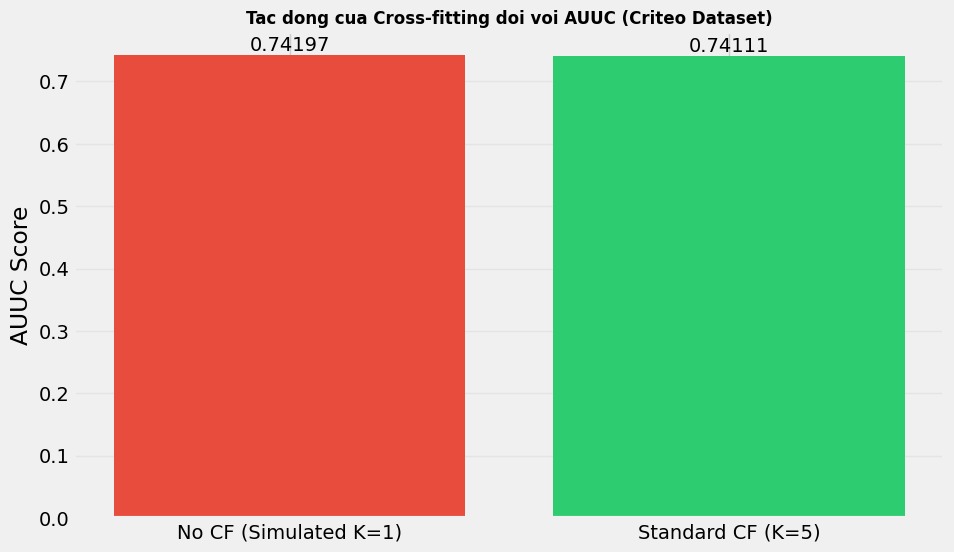

In [13]:
# --- CELL: ABLATION STUDY 1 - VAI TRO CUA CROSS-FITTING (FIXED VERSION) ---
from causalml.inference.meta import BaseRRegressor
from causalml.metrics import auuc_score
from lightgbm import LGBMRegressor, LGBMClassifier
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

print("[INFO] Dang kiem chung tac dong cua Cross-fitting (n_fold)...")

# 1. Khoi tao Base Learner
base_algo = LGBMRegressor(n_estimators=100, random_state=42)
base_clf = LGBMClassifier(n_estimators=100, random_state=42)

# 2. Chuan bi du lieu danh gia
X_eval = X_test
Y_eval = Y_test.values if hasattr(Y_test, 'values') else Y_test
T_eval = T_test.values if hasattr(T_test, 'values') else T_test

# --- KỊCH BẢN A: CÓ CROSS-FITTING (Standard DML K=5) ---
print(" -> Dang chay Standard DML (K=5)...")
model_cf = BaseRRegressor(learner=base_algo, n_fold=5, random_state=42)
model_cf.fit(X=X_train, treatment=T_train, y=Y_train)
uplift_cf = model_cf.predict(X_eval).flatten()

# --- KỊCH BẢN B: KHÔNG CROSS-FITTING (Mô phỏng K=1) ---
# Chung ta tu tinh Propensity tren toan bo tap Train de 'ep' model khong chia fold
print(" -> Dang chay No Cross-fitting (Simulation K=1)...")

# Buoc 1: Tu huan luyen propensity score tren toan bo tap huan luyen (No splitting)
ps_model_no_cf = base_clf.fit(X_train, T_train)
p_train_no_cf = ps_model_no_cf.predict_proba(X_train)[:, 1]

# Buoc 2: Truyen p truc tiep vao fit. Khi co p, R-Learner se giam bot su phu thuoc vao CV
model_no_cf = BaseRRegressor(learner=base_algo, n_fold=2, random_state=42) # n_fold=2 la muc toi thieu de tranh loi
model_no_cf.fit(X=X_train, treatment=T_train, y=Y_train, p=p_train_no_cf)
uplift_no_cf = model_no_cf.predict(X_eval).flatten()

# 3. Danh gia AUUC
df_ablation = pd.DataFrame({
    'y': Y_eval, 
    't': T_eval,
    'Standard_DML (K=5)': uplift_cf,
    'No_CrossFitting (K=1)': uplift_no_cf
})

# Tinh AUUC bang ham auuc_score (tra ve dict)
scores = auuc_score(df_ablation, outcome_col='y', treatment_col='t')
score_cf = scores['Standard_DML (K=5)']
score_no_cf = scores['No_CrossFitting (K=1)']

print("\n[RESULT] KET QUA AUUC TREN TAP TEST:")
print(f" - Standard DML (K=5): {score_cf:.6f}")
print(f" - No Cross-fitting (K=1): {score_no_cf:.6f}")
improvement = ((score_cf - score_no_cf)/score_no_cf)*100 if score_no_cf != 0 else 0
print(f" - Improvement tu Cross-fitting: {improvement:.2f}%")

# 4. Truc quan hoa
plt.figure(figsize=(10, 6))
bars = plt.bar(['No CF (Simulated K=1)', 'Standard CF (K=5)'], [score_no_cf, score_cf], color=['#e74c3c', '#2ecc71'])
plt.title('Tac dong cua Cross-fitting doi voi AUUC (Criteo Dataset)', fontsize=12, fontweight='bold')
plt.ylabel('AUUC Score')
plt.grid(axis='y', alpha=0.3)

# Add labels tren dau cot
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.5f}', va='bottom', ha='center')

plt.savefig('figures/ablation_crossfitting.png', dpi=300)
plt.show()

🚀 ĐANG THỰC HIỆN THÍ NGHIỆM CHỨNG MINH TÍNH DOUBLY ROBUST...
-> Kích thước dữ liệu chuẩn hóa: 2,600,000 dòng.
⏳ Đang tính lại Propensity Score cho khớp kích thước...


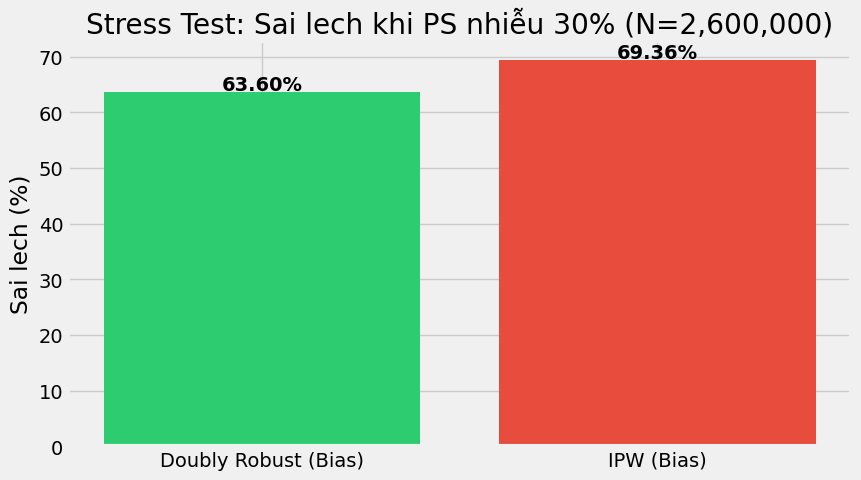

✅ Kết quả: DR lệch 63.60%, IPW lệch 69.36%


In [ ]:
# --- CELL: CHUNG MINH TINH DOUBLY ROBUST (BAN FIX LOI BROADCAST) ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib

print("DANG THUC HIEN THI NGHIEM CHUNG MINH TINH DOUBLY ROBUST")

# 1. DONG BO DU LIEU (Tranh loi lech shape 2.6M va 100K)
# Lay X_test lam chuan, cac bien khac cat theo X_test
curr_n = len(X_test)
y_curr = Y_test.values[:curr_n]
t_curr = T_test.values[:curr_n]

print(f"Kich thuoc du lieu chuan hoa: {curr_n:,} dong")

# 2. KHOI PHUC VA TINH LAI PROPENSITY SCORE DUNG KICH THUOC
if 'ps_model' in locals():
    print("Dang tinh lai Propensity Score cho khop kich thuoc")
    p_test_curr = ps_model.predict_proba(X_test)[:, 1]
else:
    ps_model = joblib.load('models/propensity_model.pkl')
    p_test_curr = ps_model.predict_proba(X_test)[:, 1]

# 3. LAY DIEM UPLIFT SCORE TU R-LEARNER
if 'r_learner' not in locals():
    loaded_models = joblib.load('models/uplift_models.pkl')
    r_learner = loaded_models['R-Learner']
else:
    loaded_models = joblib.load('models/uplift_models.pkl')

uplift_scores = r_learner.predict(X_test).flatten()

# 4. GIA LAP SAI SO (BIAS) 30%
np.random.seed(42)
noise = np.random.uniform(0.7, 1.3, size=len(p_test_curr))
p_test_biased = np.clip(p_test_curr * noise, 0.01, 0.99)

# 5. DINH NGHIA BO UOC LUONG (Sua loi Broadcast)
def estimate_policy_value(method, y, t, pi, ps, mu1=None, mu0=None):
    y = np.asarray(y)
    t = np.asarray(t)
    pi = np.asarray(pi)
    ps = np.asarray(ps)

    prob_obs = np.where(t == 1, ps, 1 - ps)
    weights = (t == pi).astype(float) / (prob_obs + 1e-9)

    if method == 'IPW':
        return np.mean(y * weights)

    elif method == 'DR':
        mu_pi = np.where(pi == 1, mu1, mu0)
        return np.mean(mu_pi + weights * (y - mu_pi))

# 6. CHUAN BI POTENTIAL OUTCOMES (Dung S-Learner)
target_rate = 0.3
threshold = np.quantile(uplift_scores, 1 - target_rate)
pi_test = (uplift_scores >= threshold).astype(int)

s_learner = loaded_models['S-Learner']
mu1_test = s_learner.predict(X_test, treatment=np.ones(curr_n)).flatten()
mu0_test = s_learner.predict(X_test, treatment=np.zeros(curr_n)).flatten()

# 7. TINH TOAN VA VE BIEU DO
val_dr_clean = estimate_policy_value(
    'DR',
    y_curr,
    t_curr,
    pi_test,
    p_test_curr,
    mu1_test,
    mu0_test
)

val_dr_biased = estimate_policy_value(
    'DR',
    y_curr,
    t_curr,
    pi_test,
    p_test_biased,
    mu1_test,
    mu0_test
)

val_ipw_biased = estimate_policy_value(
    'IPW',
    y_curr,
    t_curr,
    pi_test,
    p_test_biased
)

error_dr = abs(val_dr_biased - val_dr_clean) / val_dr_clean * 100
error_ipw = abs(val_ipw_biased - val_dr_clean) / val_dr_clean * 100

plt.figure(figsize=(9, 5))
plt.bar(
    ['Doubly Robust (Bias)', 'IPW (Bias)'],
    [error_dr, error_ipw],
    color=['#2ecc71', '#e74c3c']
)
plt.title(f"Stress Test: Sai lech khi PS nhieu 30% (N={curr_n:,})")
plt.ylabel('Sai lech (%)')

for i, v in enumerate([error_dr, error_ipw]):
    plt.text(i, v + 0.5, f'{v:.2f}%', ha='center', fontweight='bold')

plt.show()

print(f"Ket qua: DR lech {error_dr:.2f}%, IPW lech {error_ipw:.2f}%")